In [1]:
import sys
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.decomposition as dec
import sklearn.model_selection as modsel
import sklearn.preprocessing as prep
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix as cm

# 0. Define some functions

In [3]:
def split(dataset, column):
    X, Y = dataset.drop(column, axis=1), dataset[column]
    return X, Y

def tt_split(X, Y, ts=0.5, rs=None, sh=False):
    X_train, X_test, Y_train, Y_test = modsel.train_test_split(X, Y, train_size=ts, random_state=rs, shuffle=sh)
    return X_train, X_test, Y_train, Y_test

def extremums(array):
    extras = []
    for parameter in array:
        new_extras = [min(parameter), max(parameter)]
        extras.append(new_extras)
    return extras

def normalize(array):
    minimum, maximum = min(array), max(array)
    for i in range(len(array)):
        array[i] = (array[i]-minimum)/maximum

def test_metrics(test, predicted):
    print(cm(test, predicted)) 
    print("\n Mean Squeared Error =", mse(test, predicted))
    
def pdf_plot(candidates):
    fig, ax = plt.subplots(len(candidates),5,figsize=(20,len(candidates)*6))
    for n in range(len(candidates)):
        feat = candidates[n]
        for i in range(5):
            sns.distplot(np.array(known.loc[known['jobsat']==i+1][feat]), kde=True, ax=ax[n,i], color="Blue")
            ax[n,0].set_ylabel(feat)
            ax[n,i].set_title(i+1)

### Dataset description

In [4]:
dataframe = pd.read_excel("job_satisfaction_train.xlsx", sheet_name = "demo")

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 29 columns):
age         6400 non-null int64
marital     6400 non-null int64
address     6400 non-null int64
income      6400 non-null int64
inccat      6400 non-null int64
car         6400 non-null float64
carcat      6400 non-null int64
ed          6400 non-null int64
employ      6400 non-null int64
retire      6400 non-null int64
empcat      6400 non-null int64
jobsat      5400 non-null float64
gender      6400 non-null object
reside      6400 non-null int64
wireless    6400 non-null int64
multline    6400 non-null int64
voice       6400 non-null int64
pager       6400 non-null int64
internet    6400 non-null int64
callid      6400 non-null int64
callwait    6400 non-null int64
owntv       6400 non-null int64
ownvcr      6400 non-null int64
owncd       6400 non-null int64
ownpda      6400 non-null int64
ownpc       6400 non-null int64
ownfax      6400 non-null int64
news        6400 non-nul

### Simple changes

In [6]:
dataframe["gender"] = np.where(dataframe["gender"]=="f", np.int64(1), np.int64(0))

### Split for known and unknown data

In [7]:
known, predict = dataframe.iloc[0:5400], dataframe.iloc[5400:]

In [27]:
# plt.figure(figsize=(20,10))
# sns.distplot(train.jobsat, color="tomato")
# plt.title("jobsat in train")
# plt.ylabel("Density");

# 1. Preprocessing

In [55]:
x_known, y_known = split(known, column="jobsat")
yknown = np.array(y_known)

In [56]:
x_predict, y_predict = split(predict, column="jobsat")
ypredict = np.array(y_predict)

### 1.1 Features extraction

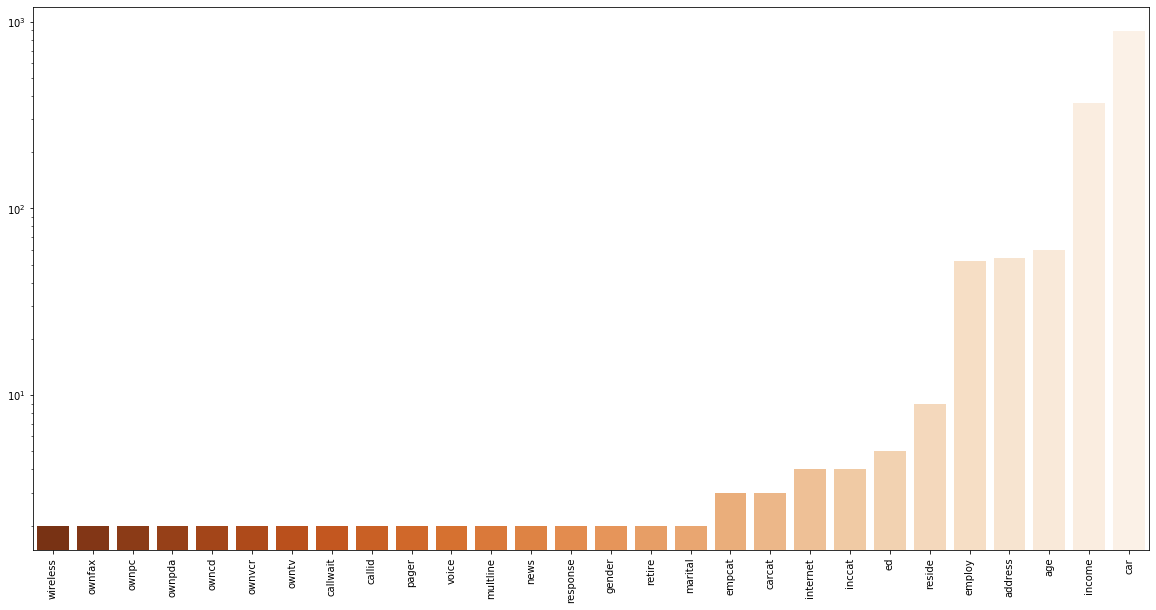

In [9]:
features = list(x_known.dtypes.index.values)
unique_counts = x_known.loc[:, features].nunique().sort_values()
plt.figure(figsize=(20,10))
sns.barplot(unique_counts.index, unique_counts.values, palette="Oranges_r")
plt.xticks(rotation=90)
plt.yscale("log");

In [10]:
bin_candidates = [elem for elem in features if len(set(x_known[elem])) == 2]
num_candidates = [elem for elem in features if len(set(x_known[elem])) >= 10**1.5]
cat_candidates = list(set(features) - set(num_candidates) - set(bin_candidates))

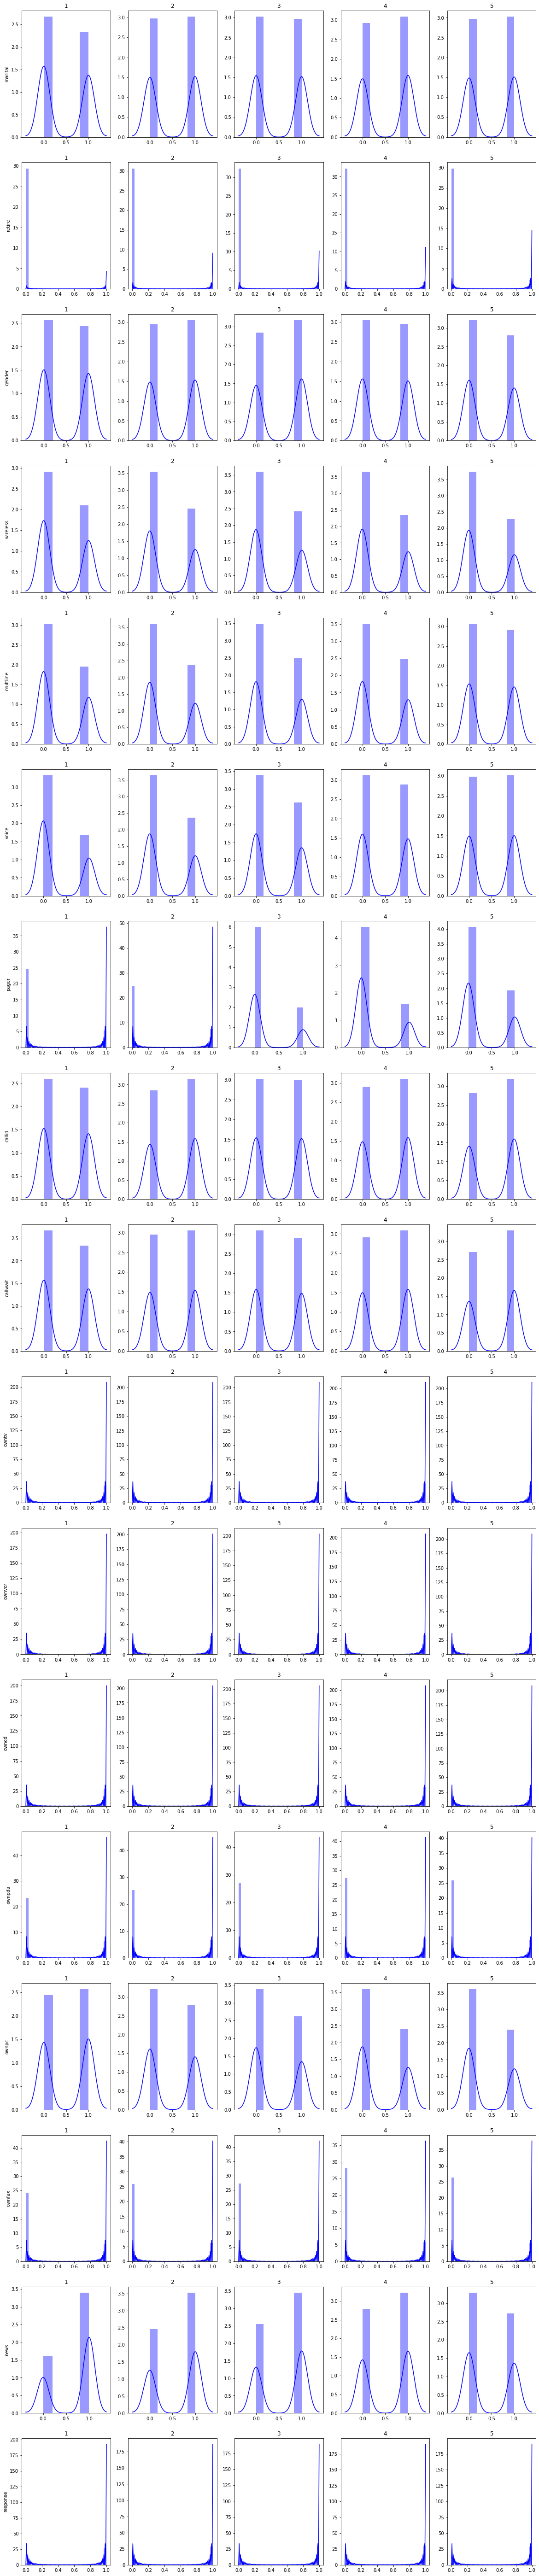

In [11]:
#bin_candidates
pdf_plot(bin_candidates)

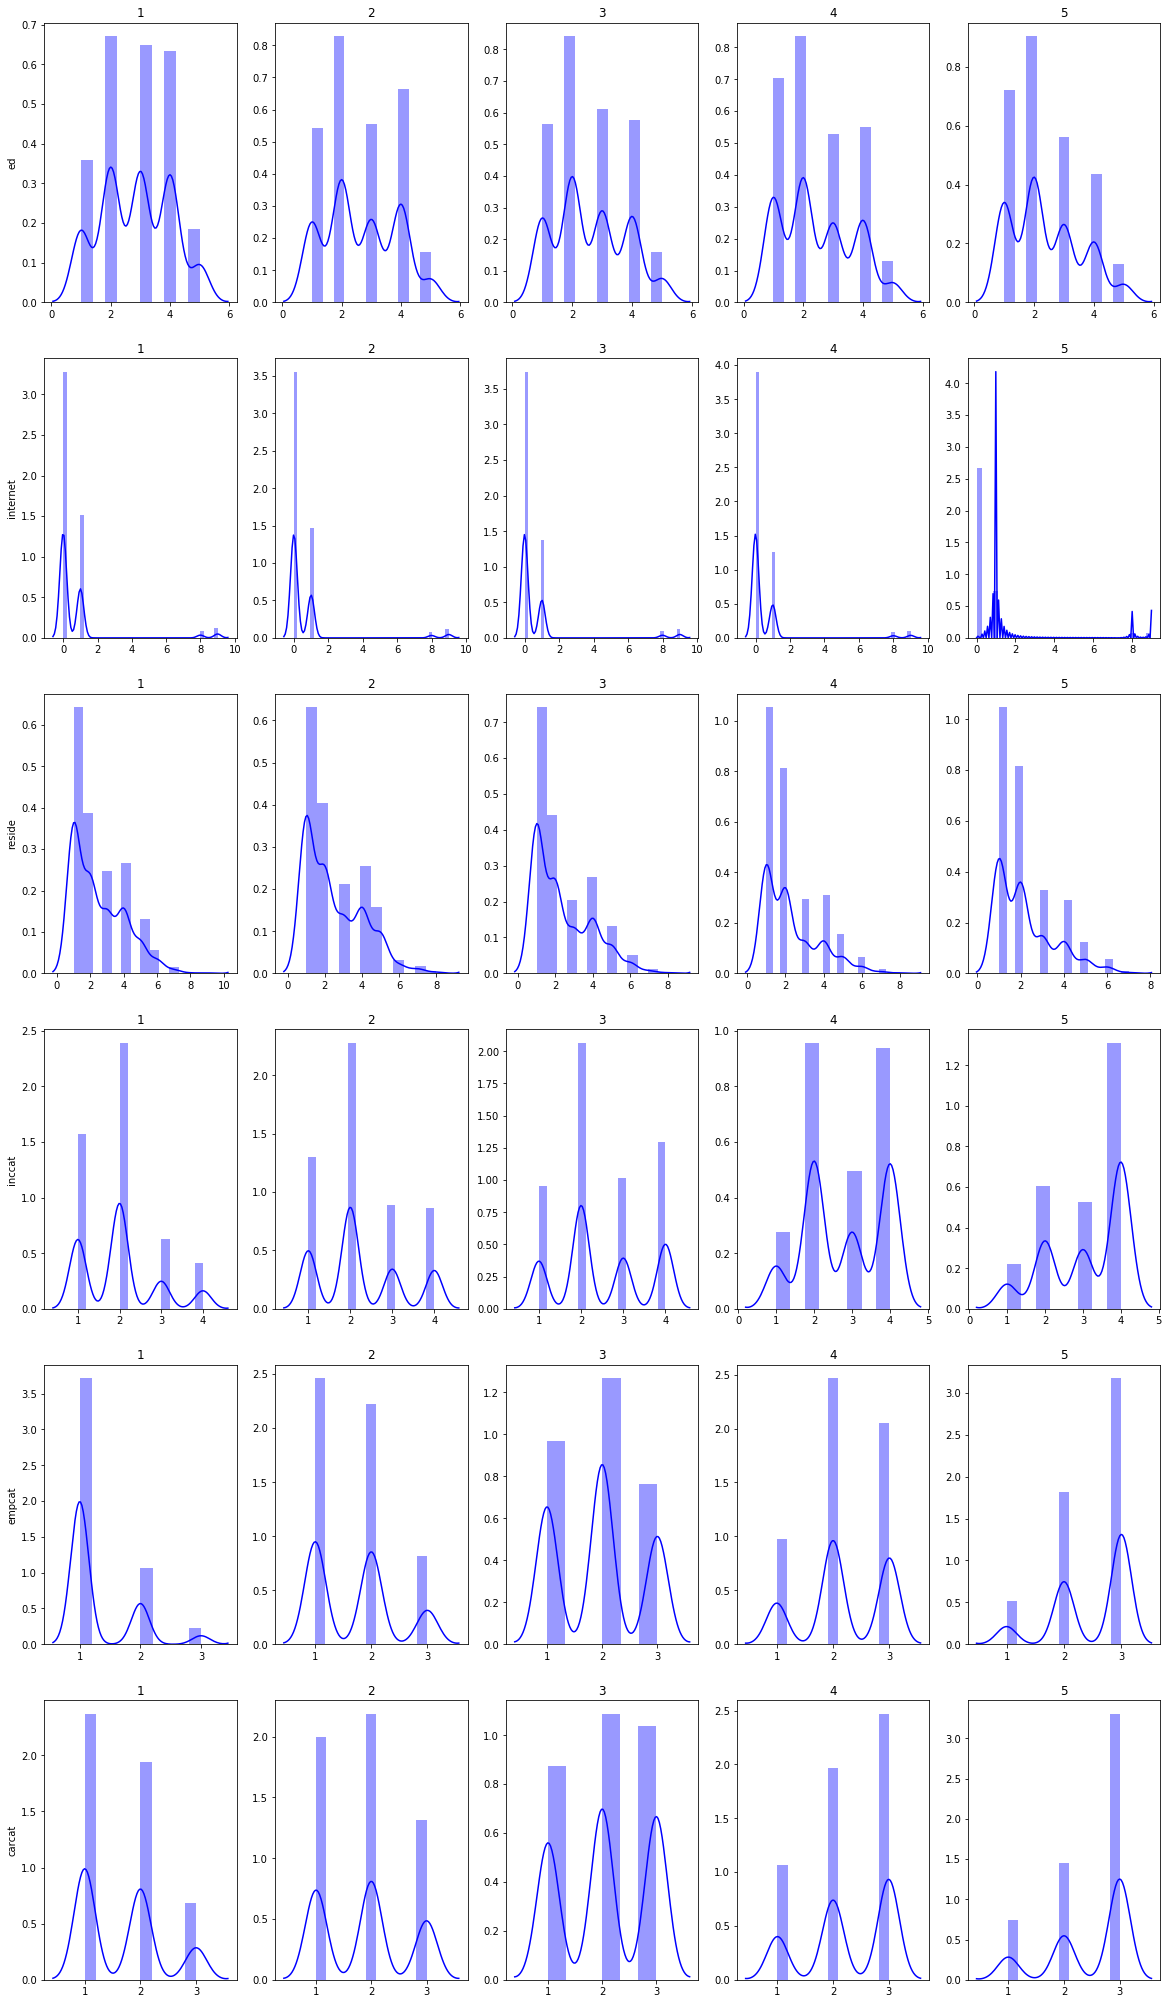

In [12]:
#cat_candidates
pdf_plot(cat_candidates)

In [109]:
final_candidates = list(set(features) - set(bin_candidates))

In [76]:
xknown = np.array(x_known.loc[:, final_vandidates])

### 1.2 Normalization

In [77]:
del extras #if extras already exists
extras = extremums(xknown.T)

In [78]:
#Choose one

for array in xknown.T:
    normalize(array)

# xknown = prep.StandardScaler().fit(xknown).transform(xknown)

# 2. Models + selection

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble

### 2.1 Train - Test split

In [110]:
x_train, x_test, y_train, y_test = tt_split(xknown, yknown, ts=0.8, rs=1, sh=True)

### 2.2 Choose some model

In [49]:
#KNC
KNC = KNeighborsClassifier()
KNC.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [111]:
#ABC
ABC = ensemble.AdaBoostClassifier()
ABC.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [105]:
#RFC
RFC = ensemble.RandomForestClassifier(n_estimators=100, criterion="gini", min_samples_leaf=10, min_samples_split=3)
RFC.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### 2.3 Check metrics

In [51]:
#KNC
test_metrics(y_test, KNC.predict(x_test))

[[99 38 21 21  5]
 [77 55 39 36 17]
 [49 50 49 53 39]
 [31 38 49 62 53]
 [18 29 38 56 58]]

 Mean Squeared Error = 2.3601851851851854


In [112]:
#ABC
test_metrics(y_test, ABC.predict(x_test))

[[108  22  20  22  12]
 [ 65  31  50  51  27]
 [ 36  24  40  76  64]
 [ 18  18  32  72  93]
 [  4   8  26  51 110]]

 Mean Squeared Error = 2.0407407407407407


In [106]:
#RFC
test_metrics(y_test, RFC.predict(x_test))

[[104  29  23  19   9]
 [ 54  51  47  43  29]
 [ 32  51  31  55  71]
 [ 16  29  39  73  76]
 [  3  11  24  52 109]]

 Mean Squeared Error = 1.9981481481481482


In [114]:
#Fitting to metric
#RFC
l = []
for elem in RFC.predict(x_test):
    if 1<elem and elem<5:
        l.append(3)
    elif elem==1:
        l.append(2)
    elif elem==5:
        l.append(4)
    else:
        l.append(elem)

test_metrics(y_test, np.array(l))

[[  0 104  71   9   0]
 [  0  54 141  29   0]
 [  0  32 137  71   0]
 [  0  16 141  76   0]
 [  0   3  87 109   0]]

 Mean Squeared Error = 1.4055555555555554


In [20]:
#Why this dataset is pretty bad
print("Mean Squeared Error =", mse(y_test, np.array([3 for i in range(len(y_test))])))

Mean Squeared Error = 1.8416666666666666


### 2.4 Cross-validation and hyperparameter optimization

In [21]:
#RFC
samples_leaf, samples_split = range(1,11), range(2,12)
main = []
main_bar = tqdm(range(len(samples_leaf)))
inside_bar = tqdm(total=(len(samples_split)))
for i in main_bar:
    sl = samples_leaf[i]
    inside = []
    for ss in samples_split:
        x_train, x_test, y_train, y_test = tt_split(xknown, yknown, ts=0.8, rs=1, sh=True)
        RFC = ensemble.RandomForestClassifier(n_estimators=100, criterion="gini", min_samples_leaf=sl, min_samples_split=ss)
        RFC.fit(x_train, y_train)
        inside.append(round(mse(y_test, RFC.predict(x_test)), 4))
        inside_bar.update()
    inside_bar.refresh()
    inside_bar.reset()
    main.append(inside)
    
print(np.array(main))


[[2.1935 2.1963 2.2074 2.1194 2.1019 2.0713 2.0815 2.0676 2.0463 2.0324]
 [2.1065 2.1389 2.1315 2.1176 2.0537 2.0833 2.0287 2.0435 2.038  2.0611]
 [2.1157 2.0778 1.9981 2.0315 2.0454 1.9843 2.0222 2.0074 1.9796 1.9991]
 [1.9815 2.0583 2.0083 2.0861 1.9843 1.9583 2.0556 1.9546 1.9315 1.9407]
 [1.9269 2.0139 2.0074 1.9444 1.9713 2.0102 1.9898 1.9611 1.9491 2.0176]
 [1.9417 1.9676 1.9417 2.0046 1.9769 1.888  1.9417 1.9343 1.9796 1.9963]
 [1.9759 1.975  1.9407 2.0278 1.9667 2.0148 1.9694 1.9472 1.9593 1.9657]
 [1.9213 2.0157 1.9935 1.9759 1.9676 2.0037 1.9676 1.9574 1.9361 1.9694]
 [1.9315 2.0083 1.963  1.9407 1.9509 1.9843 1.9759 1.963  1.9676 2.0019]
 [1.9519 1.9046 1.9889 1.9667 1.9731 1.987  1.9676 1.9861 1.9704 1.9833]]


# 3. Prediction

In [83]:
xpredict = np.array(x_predict.loc[:, list(set(features) - set(bin_candidates))])

In [100]:
# extras

In [85]:
for j in range(len(xpredict.T)):
    array = xpredict.T[j]
    for i in range(len(array)):
        array[i]=(array[i]-extras[j][0])/extras[j][1]

In [102]:
# xknown

In [101]:
# xpredict

In [99]:
# x_train, x_test, y_train, y_test = tt_split(xknown, yknown, ts=1, rs=0, sh=False)
RFC = ensemble.RandomForestClassifier(n_estimators=100, criterion="gini", min_samples_leaf=10, min_samples_split=3)
RFC.fit(xknown, yknown)
prediction = RFC.predict(xpredict)

In [92]:
#some chits
l = []
for elem in prediction:
    if 1<elem and elem<5:
        l.append(3)
    elif elem==1:
        l.append(2)
    elif elem==5:
        l.append(4)
    else:
        l.append(elem)

In [98]:
df = pd.DataFrame(np.array(l))
df.to_csv('RFC_prediction.csv')
df.to_excel('RFC_prediction.xlsx', sheet_name='prediction')